In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import randint, uniform

pd.options.display.float_format = '{:.2f}'.format

## IMPORT & EXPLORE

In [2]:
krisha_almaty_rental = pd.read_csv(r"C:\Users\User\Desktop\krisha_bot\data\krisha_almaty_rental.csv.gz")

In [118]:
krisha_almaty_rental.sample(5)

,id,floor,total_floors,area_sqm,rooms,bathroom,furniture,parking,security,price,url,bathroom_code,furniture_code,parking_code,security_code,district_name,district_name_code
1067,699375275,1,5,40.00,1,разделен,"кровать, обеденный стол, шкаф для одежды, кухо...",нет/неизвестно,нет/неизвестно,165000,https://krisha.kz/a/show/699375275,1,20,1,32,Жетысуский р-н,5
4154,697345319,5,5,59.00,2,"разделен, совмещен","кровать, обеденный стол, шкаф для одежды, кухо...",нет/неизвестно,нет/неизвестно,220000,https://krisha.kz/a/show/697345319,2,18,1,32,Алатауский р-н,0
4435,762261697,1,4,29.00,1,совмещен,"обеденный стол, шкаф для одежды, кухонный гарн...",нет/неизвестно,нет/неизвестно,200000,https://krisha.kz/a/show/762261697,3,45,1,32,Ауэзовский р-н,3
234,696885546,1,4,60.00,2,разделен,"кровать, обеденный стол, шкаф для одежды, кухо...",нет/неизвестно,нет/неизвестно,300000,https://krisha.kz/a/show/696885546,1,20,1,32,Жетысуский р-н,5
2371,1000706576,8,9,84.00,3,"разделен, совмещен","кровать, обеденный стол, шкаф для одежды, кухо...",нет/неизвестно,нет/неизвестно,280000,https://krisha.kz/a/show/1000706576,2,20,1,32,Алмалинский р-н,1


<Axes: >

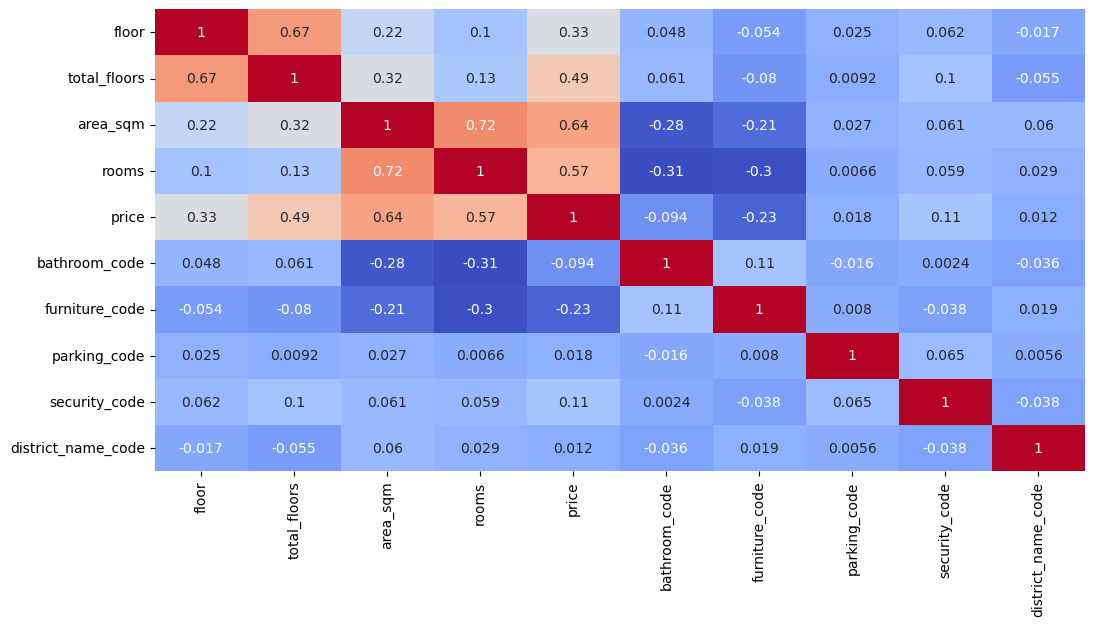

In [119]:
krisha_almaty_rental_corr = krisha_almaty_rental.select_dtypes(include = ('number')).drop(columns = ['id']).corr()

plt.figure(figsize = (12,6))

sns.heatmap( data = krisha_almaty_rental_corr,
             cmap = 'coolwarm',
             cbar = False,
             annot = True) 


## MODEL BUILD

In [3]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

krisha_almaty_rental_features = krisha_almaty_rental.select_dtypes(include = ('number')).drop(columns = ['id'])

In [135]:
krisha_almaty_rental_features

,floor,total_floors,area_sqm,rooms,price,bathroom_code,furniture_code,parking_code,security_code,district_name_code
0,3,4,65.00,3,280000,1,20,1,32,1
1,3,6,42.00,2,250000,3,43,1,41,4
2,1,6,50.00,2,250000,3,20,1,32,7
3,12,19,90.00,3,470000,1,20,1,32,2
4,2,2,50.00,1,140000,3,20,1,32,2
...,...,...,...,...,...,...,...,...,...,...
6130,2,12,56.00,2,450000,3,18,1,47,4
6131,3,5,60.00,2,400000,3,20,1,32,6
6132,5,9,19.20,1,120000,2,20,1,32,0
6133,1,5,45.00,1,200000,3,17,1,32,0


In [136]:
kmeans_results = []

for k in range( 5,100,1 ):

    krisha_almaty_rental_kmeans_pipeline = Pipeline( [ ('scaler',StandardScaler()),
                                                       ('kmeans',KMeans( n_clusters = k ))] )

    krisha_almaty_rental_kmeans_pipeline.fit(krisha_almaty_rental_features)

    kmeans_results.append( {'K' : k,
                            'Inertia' : krisha_almaty_rental_kmeans_pipeline.named_steps['kmeans'].inertia_} )


Optimal number of clusters (elbow): K = 27


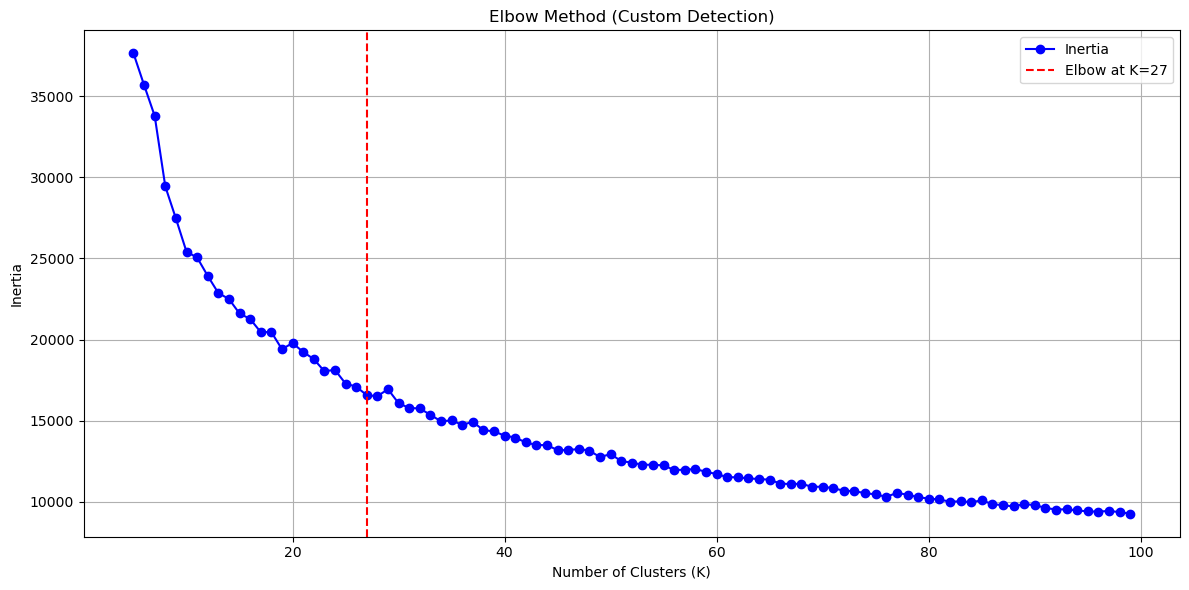

In [163]:
# Extract K values and inertia from your results
Ks = [res['K'] for res in kmeans_results]
inertias = [res['Inertia'] for res in kmeans_results]

# Custom elbow finder using max perpendicular distance to line
def find_elbow(k_values, inertia_values):
    p1 = np.array([k_values[0], inertia_values[0]])
    p2 = np.array([k_values[-1], inertia_values[-1]])
    
    distances = []
    for i in range(len(k_values)):
        p = np.array([k_values[i], inertia_values[i]])
        d = np.abs(np.cross(p2 - p1, p1 - p)) / np.linalg.norm(p2 - p1)
        distances.append(d)
        
    elbow_index = np.argmax(distances)
    return k_values[elbow_index]

# Find elbow K
elbow_k = find_elbow(Ks, inertias)
print(f"Optimal number of clusters (elbow): K = {elbow_k}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(Ks, inertias, 'bo-', label='Inertia')
plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Elbow at K={elbow_k}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Custom Detection)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the figure
plt.figure(figsize=(12, 6))
plt.plot(Ks, inertias, 'bo-', label='Inertia')
plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Elbow at K={elbow_k}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Custom Detection)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('elbow_method_kmeans.png', dpi=300)
plt.close()


In [4]:
krisha_almaty_rental_kmeans27_pipeline = Pipeline( [ ('scaler',StandardScaler()),
                                                     ('kmeans',KMeans( n_clusters = 27 ))] )

krisha_almaty_rental_kmeans27_pipeline.fit(krisha_almaty_rental_features)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=27))])

In [5]:
test_features_dict = {
    'floor': [12],
    'total_floors': [20],
    'area_sqm': [95],
    'rooms': [3],
    'price': [42000],
    'bathroom_code': [2],
    'furniture_code': [18],
    'parking_code': [1],
    'security_code': [41],
    'district_name_code': [1]
}

In [6]:
krisha_almaty_rental_kmeans27_pipeline.predict(pd.DataFrame(test_features_dict))

array([11])

In [142]:
krisha_almaty_rental['kmeans27_cluster'] = krisha_almaty_rental_kmeans27_pipeline.predict(krisha_almaty_rental_features)

In [143]:
krisha_almaty_rental_cluster_groupping = krisha_almaty_rental.groupby('kmeans27_cluster').agg( mean_rent_price = ('price','mean'),
                                                                                               median_rent_price = ('price','median'),
                                                                                               number_of_listings = ('id','count')).reset_index()

<Axes: xlabel='kmeans27_cluster', ylabel='median_rent_price'>

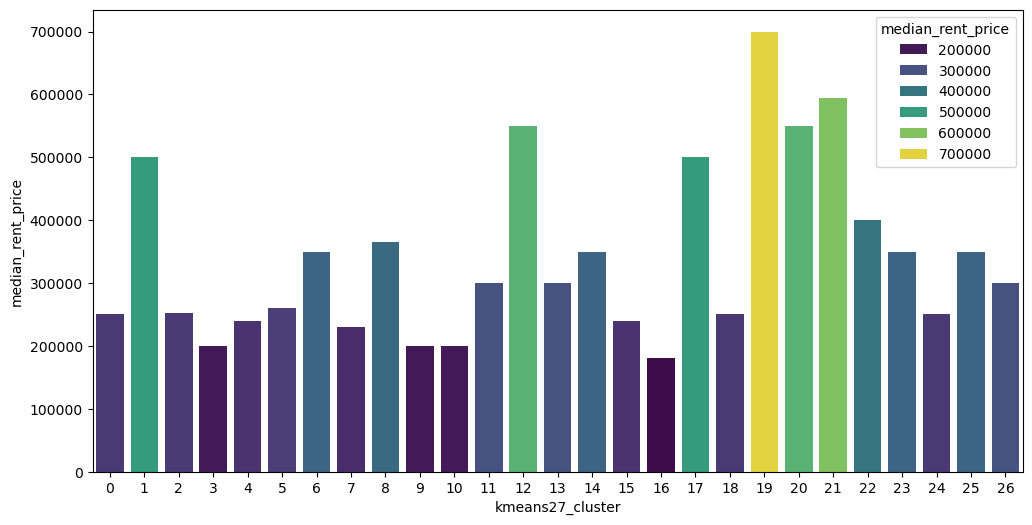

In [144]:
plt.figure(figsize=(12, 6))

sns.barplot( data = krisha_almaty_rental_cluster_groupping,
             x = 'kmeans27_cluster',
             y = 'median_rent_price',
             hue = 'median_rent_price',
             palette = 'viridis' )


<Axes: xlabel='kmeans27_cluster', ylabel='mean_rent_price'>

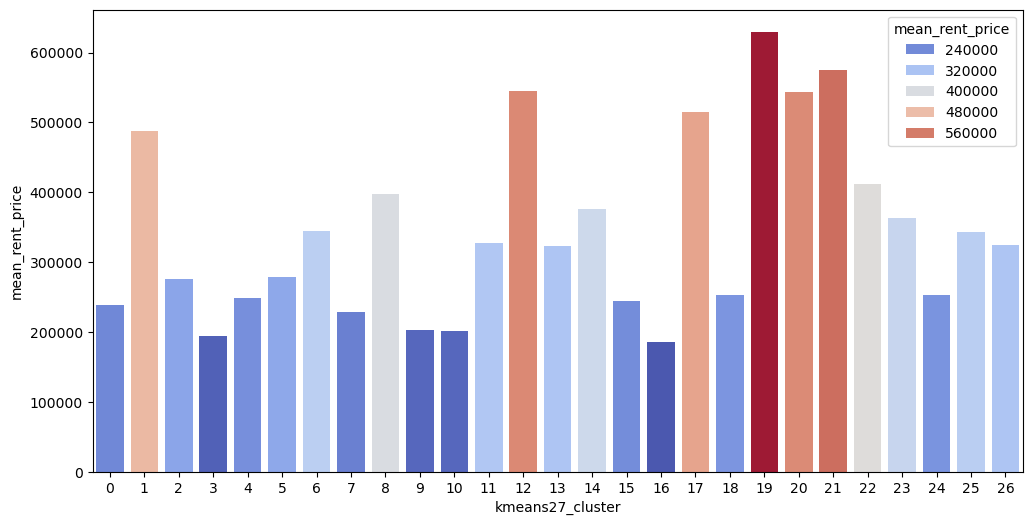

In [145]:
plt.figure(figsize=(12, 6))

sns.barplot( data = krisha_almaty_rental_cluster_groupping,
             x = 'kmeans27_cluster',
             y = 'mean_rent_price',
             hue = 'mean_rent_price',
             palette = 'coolwarm' )

In [146]:
krisha_almaty_rental_cluster_groupping

,kmeans27_cluster,mean_rent_price,median_rent_price,number_of_listings
0,0,238937.49,250000.00,384
1,1,487484.66,500000.00,163
2,2,275821.43,252500.00,364
3,3,194436.44,200000.00,480
4,4,247991.45,240000.00,234
5,5,278636.36,260000.00,44
6,6,344215.05,350000.00,465
7,7,229035.71,230000.00,266
8,8,397958.98,365000.00,49
9,9,202687.07,200000.00,294


In [150]:
krisha_almaty_rental_features.columns

Index(['floor', 'total_floors', 'area_sqm', 'rooms', 'price', 'bathroom_code',
       'furniture_code', 'parking_code', 'security_code',
       'district_name_code'],
      dtype='object')

In [162]:
mappings = {}

for column in ['bathroom', 'furniture', 'parking', 'security', 'district_name']:
    mapping = (krisha_almaty_rental[[column, f'{column}_code']]
               .dropna()
               .drop_duplicates()
               .set_index(column)[f'{column}_code']
               .to_dict())
    mappings[column] = mapping


mappings

{'bathroom': {'разделен': 1,
  'совмещен': 3,
  'разделен, совмещен': 2,
  '2 с/у и более': 0},
 'furniture': {'кровать, обеденный стол, шкаф для одежды, кухонный гарнитур, рабочий стол, диван': 20,
  'обеденный стол, шкаф для одежды, диван': 43,
  'кровать, обеденный стол, шкаф для одежды, кухонный гарнитур, рабочий стол': 19,
  'кровать, обеденный стол, шкаф для одежды, кухонный гарнитур, диван': 18,
  'обеденный стол, шкаф для одежды, кухонный гарнитур, диван': 45,
  'обеденный стол, шкаф для одежды, кухонный гарнитур, рабочий стол': 46,
  'обеденный стол, шкаф для одежды, кухонный гарнитур, рабочий стол, диван': 47,
  'кровать, шкаф для одежды, кухонный гарнитур, диван': 26,
  'кровать, шкаф для одежды, кухонный гарнитур, рабочий стол, диван': 28,
  'обеденный стол, кухонный гарнитур, рабочий стол': 38,
  'кровать, обеденный стол, шкаф для одежды, кухонный гарнитур': 17,
  'обеденный стол, кухонный гарнитур, диван': 37,
  'кровать, обеденный стол': 7,
  'шкаф для одежды, диван': 52

## SAVE

In [7]:
from joblib import dump

dump(krisha_almaty_rental_kmeans27_pipeline,"krisha_almaty_rental_kmeans27_pipeline.joblib")

['krisha_almaty_rental_kmeans27_pipeline.joblib']

In [8]:
#### TEST LOADING

from joblib import load

krisha_almaty_rental_kmeans27_pipeline = load(r"C:\Users\User\Desktop\krisha_bot\models\krisha_almaty_rental_kmeans27_pipeline.joblib")


In [9]:
krisha_almaty_rental_kmeans27_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=27))])

In [36]:
test_features_dict2 = {
    'floor': [3],
    'total_floors': [5],
    'area_sqm': [45],
    'rooms': [3],
    'price': [150000],
    'bathroom_code': [1],
    'furniture_code': [1],
    'parking_code': [0],
    'security_code': [1],
    'district_name_code': [3]
}

In [37]:
krisha_almaty_rental_kmeans27_pipeline.predict(pd.DataFrame(test_features_dict2))

array([1])